# Starbucks's stock market prediction using LSTM  

### In this example we will go over a simple LSTM model using Python and PyTorch to predict the Volume of Starbucks’ stock price.



Some imports 

In [11]:
import matplotlib.pyplot as plt 
import torch
import torchvision
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler


Load the dataset 

In [9]:
df = pd.read_csv('SBUX.csv', index_col = 'Date', parse_dates=True)

df.head(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-12-11,86.260002,86.870003,85.849998,86.589996,79.847786,4921900
2019-12-12,88.000000,88.889999,87.540001,88.209999,81.341652,10282100
2019-12-13,88.019997,88.790001,87.580002,88.669998,81.765839,6714100
2019-12-16,89.139999,89.300003,88.430000,88.779999,81.867249,6705600
2019-12-17,88.870003,88.970001,87.470001,88.129997,81.267883,7296900


### original trend 

<AxesSubplot: title={'center': 'Star Bucks Stock Volume'}, xlabel='Date'>

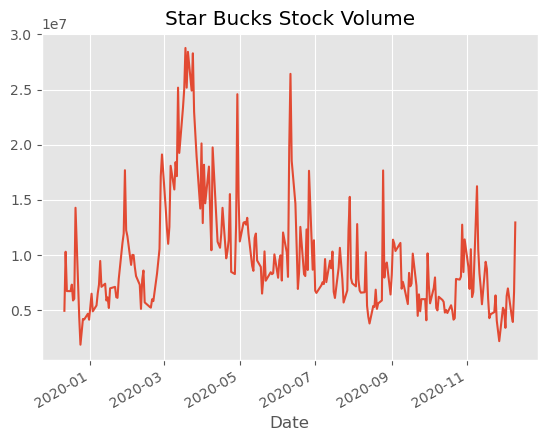

In [10]:
plt.style.use('ggplot')
df['Volume'].plot(label='CLOSE', title='Star Bucks Stock Volume')

### Check for GPU 

In [4]:
#Check if GPU is available
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print("Device:",device)

Device: cpu


### Consider normalisation 

In [12]:
X = df.iloc[:, :-1]
y = df.iloc[:, 5:6] 
mm = MinMaxScaler()
ss = StandardScaler()


X_ss = ss.fit_transform(X)
y_mm = mm.fit_transform(y) 

### Split the dataset 

In [17]:
from sklearn.model_selection import train_test_split

#X_train, X_test, y_train, y_test = train_test_split(X_ss, y_mm, test_size=0.20, random_state=42)
X_train = X_ss[:200, :]
X_test = X_ss[200:, :]

y_train = y_mm[:200, :]
y_test = y_mm[200:, :] 
print("Training Shape", X_train.shape, y_train.shape)
print("Testing Shape", X_test.shape, y_test.shape) 

Training Shape (200, 5) (200, 1)
Testing Shape (53, 5) (53, 1)


### Preparing for the PyTorch

In [18]:
import torch.nn as nn
from torch.autograd import Variable 

X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test)) 

print(X_train_tensors.shape)

torch.Size([200, 5])


### Reshaping 

In [19]:
#reshaping to rows, timestamps, features

X_train_tensors_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
X_test_tensors_final = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1]))

print("Training Shape", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors_final.shape, y_test_tensors.shape)

Training Shape torch.Size([200, 1, 5]) torch.Size([200, 1])
Testing Shape torch.Size([53, 1, 5]) torch.Size([53, 1])


### LSTM network 

In [22]:
class LSTM_sb(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM_sb, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) #lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) #fully connected 1
        self.fc = nn.Linear(128, num_classes) #fully connected last layer

        self.relu = nn.ReLU()
    
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) #first Dense
        out = self.relu(out) #relu
        out = self.fc(out) #Final Output
        return out

In [25]:
!python -m pip install torchsummary 

In [26]:
from torchsummary import summary 
#summary(model, input_size = (3, 64, 64), batch_size = -1)

### hyperparameters 

In [43]:
num_epochs = 1000 #1000 epochs
learning_rate = 0.001 #0.001 lr

input_size = 5 #number of features
hidden_size = 2 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

In [44]:
lstm_model = LSTM_sb(num_classes, input_size, hidden_size, num_layers, X_train_tensors_final.shape[1])
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=learning_rate)

In [45]:

lstm_model.to(device)
for epoch in range(num_epochs):
  outputs = lstm_model(X_train_tensors_final) #forward pass
  optimizer.zero_grad() #caluclate the gradient, manually setting to 0
 
  # obtain the loss function
  loss = criterion(outputs, y_train_tensors)
 
  loss.backward() #calculates the loss of the loss function
 
  optimizer.step() #improve from loss, i.e backprop
  if epoch % 100 == 0:
    print(f"Epoch: {epoch}, loss: {loss.item()}")

Epoch: 0, loss: 0.08908718079328537
Epoch: 100, loss: 0.022884445264935493
Epoch: 200, loss: 0.019234009087085724
Epoch: 300, loss: 0.01822023093700409
Epoch: 400, loss: 0.017828743904829025
Epoch: 500, loss: 0.01758691482245922
Epoch: 600, loss: 0.017366470769047737
Epoch: 700, loss: 0.017026051878929138
Epoch: 800, loss: 0.01664968766272068
Epoch: 900, loss: 0.01621771976351738


### The model is trained now. We can make preditions. <br>
### We will first convert the data into the model specific format 

In [46]:
df_X_ss = ss.transform(df.iloc[:, :-1]) #old transformers
df_y_mm = mm.transform(df.iloc[:, -1:]) #old transformers

df_X_ss = Variable(torch.Tensor(df_X_ss)) #converting to Tensors
df_y_mm = Variable(torch.Tensor(df_y_mm))
#reshaping the dataset
df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 1, df_X_ss.shape[1])) 

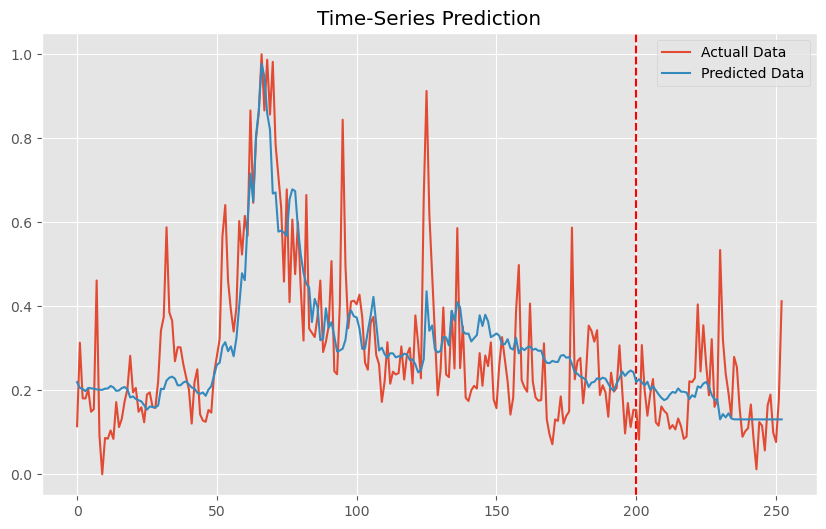

In [47]:
train_predict = lstm_model(df_X_ss)#forward pass
data_predict = train_predict.data.numpy() #numpy conversion
dataY_plot = df_y_mm.data.numpy()

#data_predict = mm.inverse_transform(data_predict) #reverse transformation
#dataY_plot = mm.inverse_transform(dataY_plot)
plt.figure(figsize=(10,6)) #plotting
plt.axvline(x=200, c='r', linestyle='--') #size of the training set

plt.plot(dataY_plot, label='Actuall Data') #actual plot
plt.plot(data_predict, label='Predicted Data') #predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.show() 